# Computing Plankton Index

In [1]:
import numpy as np
import scipy as sp
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.dates import DateFormatter


### Importing MVCO data

In [3]:

df = pd.read_csv('/D/MIT-WHOI/data/2021/biovol_concentration_by_class_time_seriesCNN_hourly.csv')
df["id"] = df.index

print(df.head())
df_filtered =pd.melt(df,id_vars = ['datetime'], var_name = 'species',value_name='biovol/mL')

               datetime  Acanthoica_quattrospina  Akashiwo  \
0  06-Jun-2006 18:56:16                 0.000000       0.0   
1  06-Jun-2006 19:18:01                 0.000000       0.0   
2  06-Jun-2006 20:23:16                 0.000000       0.0   
3  06-Jun-2006 21:17:32                 0.000000       0.0   
4  06-Jun-2006 22:25:43                34.815354       0.0   

   Alexandrium_catenella  Amphidinium  Amylax  Apedinella  \
0                    0.0          0.0     0.0    0.000000   
1                    0.0          0.0     0.0    0.000000   
2                    0.0          0.0     0.0    0.000000   
3                    0.0          0.0     0.0    0.000000   
4                    0.0          0.0     0.0   96.448108   

   Asterionellopsis_glacialis  Bacillaria  Bacillariophyceae  ...     pennate  \
0                  190.513016         0.0         311.643280  ...    0.000000   
1                    0.000000         0.0          56.404548  ...  361.366141   
2                

### Importing ClassList to group species into functional groupsfrom datetime import datetime

In [5]:
clist = pd.read_csv('/D/MIT-WHOI/data/2021/IFCB_classlist_type.csv') #importing 

clist = pd.melt(clist,id_vars = ['CNN_classlist'], var_name = 'group',value_name='in_out')

clist_filtered = clist[clist['in_out']==1]

clist_filtered = clist_filtered.rename(columns = {"CNN_classlist":'species','in_out':'present'})

print(clist_filtered.head())

merged = df_filtered.join(clist_filtered.set_index('species'),on = 'species')

print(merged.head())

                                        species   group  present
0                       Chaetoceros_tenuissimus  Diatom      1.0
1                             Cylindrotheca_min  Diatom      1.0
2                          Eucampia_morphytype1  Diatom      1.0
3  Guinardia_delicatula_TAG_Amphidinium_grazing  Diatom      1.0
4                        Hemiaulus_membranaceus  Diatom      1.0
               datetime                  species  biovol/mL            group  \
0  06-Jun-2006 18:56:16  Acanthoica_quattrospina        0.0  Coccolithophore   
0  06-Jun-2006 18:56:16  Acanthoica_quattrospina        0.0             Nano   
1  06-Jun-2006 19:18:01  Acanthoica_quattrospina        0.0  Coccolithophore   
1  06-Jun-2006 19:18:01  Acanthoica_quattrospina        0.0             Nano   
2  06-Jun-2006 20:23:16  Acanthoica_quattrospina        0.0  Coccolithophore   

   present  
0      1.0  
0      1.0  
1      1.0  
1      1.0  
2      1.0  


### converting from long to short format for data set

In [6]:
df_long = merged[['datetime','group','biovol/mL']]

df_short = df_long.pivot_table(index=["datetime"], 
                    columns='group', 
                    values='biovol/mL')

### resetting index (req'd to make sure valuable data don't become row indexes (row names))

In [7]:
df_short.head()

df_short.index.name = 'datetime'
df_short.reset_index(inplace=True)

### creating year decimal column for df_short

need to have datetime object that is =  year + (day of year/365) for the plankton index.

In [92]:
df_short['datetime'].head()

df_short['datetime'] =  pd.to_datetime(df_short['datetime'], format="%d-%b-%Y %X")

year = pd.to_numeric(df_short["datetime"].dt.year)
doy = pd.to_numeric(df_short["datetime"].dt.dayofyear).div(365)

df_short["yearday"] = year + doy

df_short['datetime'] = df_short['datetime'].dt.date

print(df_short.head())

group    datetime      Ciliate  Coccolithophore        Diatom  Dinoflagellate  \
0      2007-04-01  1952.162094       128.998273  30550.985713     2599.249141   
1      2007-04-01  1888.968813        89.118841  27507.200308     3102.500260   
2      2007-04-01  2734.251767       219.056383  25738.830229     2365.043237   
3      2007-04-01  1506.973968        73.365809  31687.382353     2894.457052   
4      2007-04-01  2232.721254        82.716600  29088.064968     2810.684279   

group  IFCB artifact         Nano    Other live  Other not alive   flagellate  \
0         670.644834  7367.429339    453.713189      5210.114861  9417.239577   
1         565.436912  8360.338310  25927.564471      3278.830726  7379.291988   
2         897.389025  8509.690338    832.300632      5582.237795  7634.988547   
3        2653.760872  8237.828202   8212.188449      2961.487625  6827.584882   
4         485.804170  8505.711531    267.929262      2237.366669  7458.138996   

group  pennatediatom      

### subsetting df_short to create smaller csv to export for plankton index submission

In [ ]:
df_dd = df_short[["year","Diatom","Dinoflagellate","Nano","Ciliate","Coccolithophore"]]

df_dd.to_csv('/D/MIT-WHOI/github_repos/plankton-index/df_dd.txt',sep= " ",index = False)

In [89]:
# df_short['datetime'].strftime("%Y%m%d")
from datetime import datetime
datetime.strptime(df_short['datetime'],'%Y%m%d')

TypeError: strptime() argument 1 must be str, not Series

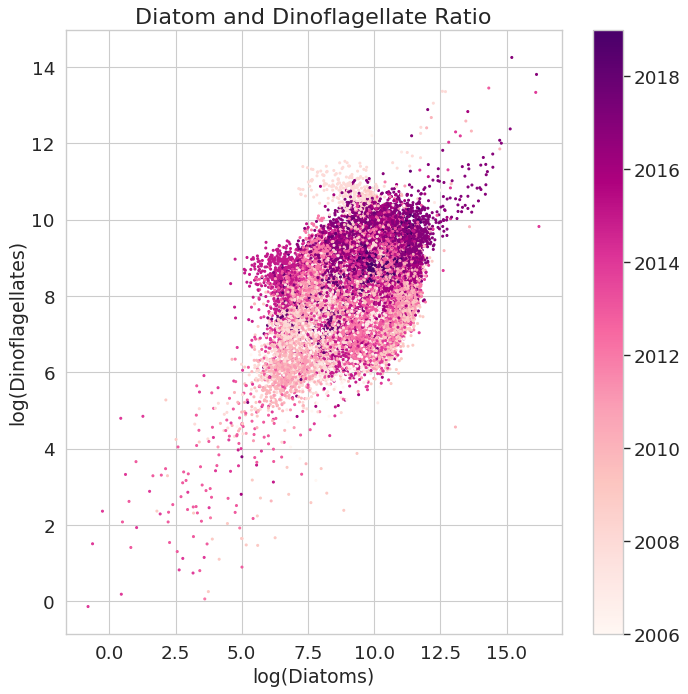

In [17]:
from matplotlib.pyplot import figure
from scipy.stats import gaussian_kde #req'd for density dot plot

figure(figsize=(10, 10), dpi=80) 

plt.scatter(np.log(df_short['Diatom']),
            np.log(df_short['Dinoflagellate']),
            c=df_short["year"],
           cmap = "RdPu",
           s = 3)
plt.colorbar()
plt.xlabel("log(Diatoms)",size = 17)
plt.ylabel("log(Dinoflagellates)",size = 17)
plt.title("Diatom and Dinoflagellate Ratio",size = 20)

sns.set(font_scale=1.5, style="whitegrid")

Text(0.5, 1.0, 'Diatom/Nano Ratio by Month of The Year')

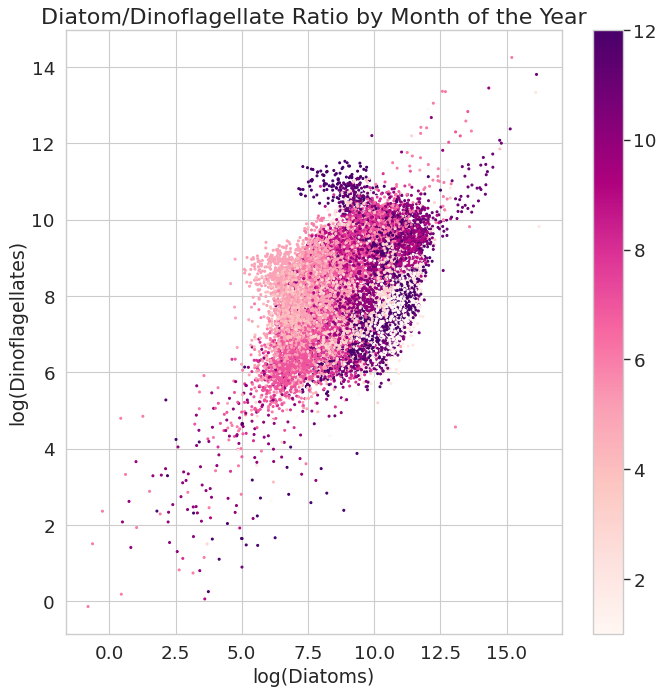

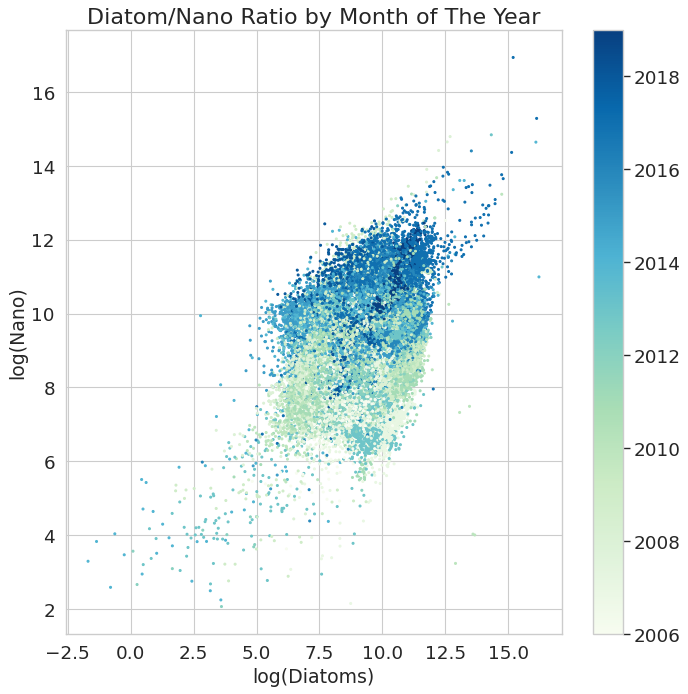

In [18]:
from matplotlib.pyplot import figure
from scipy.stats import gaussian_kde #req'd for density dot plot

figure(figsize=(10, 10), dpi=80) 

plt.scatter(np.log(df_short['Diatom']),
            np.log(df_short['Dinoflagellate']),
            c=df_short["month"],
           cmap = "RdPu",
           s = 3)

plt.colorbar()
plt.xlabel("log(Diatoms)",size = 17)
plt.ylabel("log(Dinoflagellates)",size = 17)
plt.title("Diatom/Dinoflagellate Ratio by Month of the Year",size = 20)

from matplotlib.pyplot import figure
from scipy.stats import gaussian_kde #req'd for density dot plot

figure(figsize=(10, 10), dpi=80) 

plt.scatter(np.log(df_short['Diatom']),
            np.log(df_short['Nano']),
            c=df_short["year"],
           cmap = "GnBu",
           s = 3)

plt.colorbar()
plt.xlabel("log(Diatoms)",size = 17)
plt.ylabel("log(Nano)",size = 17)
plt.title("Diatom/Nano Ratio by Month of The Year",size = 20)

Text(0.5, 1.0, 'Diatom and Nano Ratio by Month of The Year')

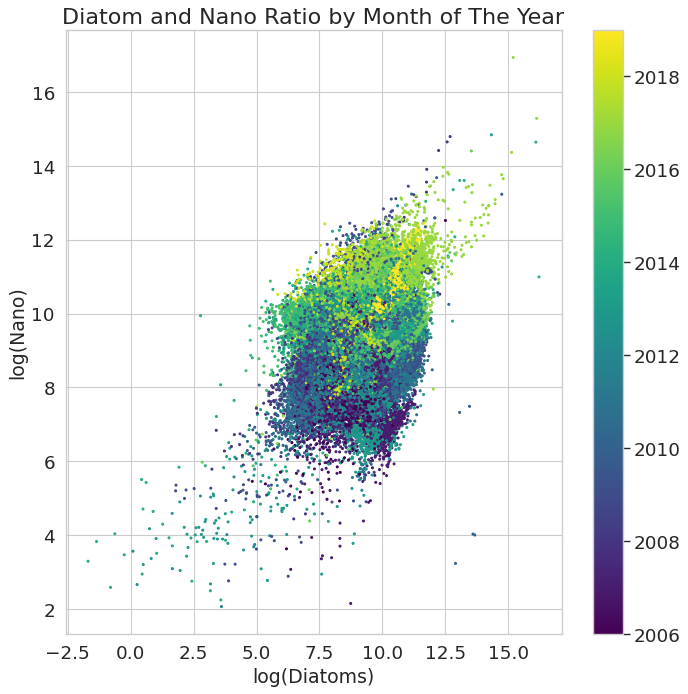

In [66]:
from matplotlib.pyplot import figure
from scipy.stats import gaussian_kde #req'd for density dot plot

figure(figsize=(10, 10), dpi=80) 

plt.scatter(np.log(df_short['Diatom']),
            np.log(df_short['Nano']),
            c=df_short["year"],
           cmap = "viridis",
           s = 3)
plt.colorbar()
plt.xlabel("log(Diatoms)",size = 17)
plt.ylabel("log(Nano)",size = 17)
plt.title("Diatom and Nano Ratio by Month of The Year",size = 20)

### trying to incorporate temperature by merging with the datetime as a key
problem is that 

### incorporating temperature data

In [91]:
dftemp = pd.read_csv("/D/MIT-WHOI/data/2021/temp_total.csv",header = None)
dftemp_time = pd.read_csv("/D/MIT-WHOI/data/2021/temp_total_time_num.csv", header = None)


dftemp = pd.concat([dftemp[col] for col in dftemp]) # data comes in as 366 x 12 column. flattening to get 1 data column 
dftemp_time = pd.concat([dftemp_time[col] for col in dftemp_time]) #also flattening for time column 
dftemp_time_conv = pd.to_datetime(dftemp_time, format='%Y%m%d', errors='ignore')
# dftemp.head()
# dftemp_time_conv.head()

dft = pd.concat([dftemp_time_conv,dftemp],axis =1) #combining into one dataframe with just datetime and temperature
dft = dft.rename(columns={0: "datetime", 1: "temp"}) #

,datetime,temp
0,2003-01-01,4.2100
1,2003-01-02,0.0000
2,2003-01-03,3.6808
3,2003-01-04,3.7418
4,2003-01-05,3.8182


In [100]:
print(dft.head())
print(df_short.head())
dft["datetime"].dtypes
df_short["datetime"].dtypes

dft['datetime'] = pd.to_datetime(dft['datetime'], format = '%Y-%m-%d')
df_short['datetime'] = pd.to_datetime(df_short["datetime"], format = '%Y-%m-%d')

    datetime    temp
0 2003-01-01  4.2100
1 2003-01-02  0.0000
2 2003-01-03  3.6808
3 2003-01-04  3.7418
4 2003-01-05  3.8182
group    datetime      Ciliate  Coccolithophore        Diatom  Dinoflagellate  \
0      2007-04-01  1952.162094       128.998273  30550.985713     2599.249141   
1      2007-04-01  1888.968813        89.118841  27507.200308     3102.500260   
2      2007-04-01  2734.251767       219.056383  25738.830229     2365.043237   
3      2007-04-01  1506.973968        73.365809  31687.382353     2894.457052   
4      2007-04-01  2232.721254        82.716600  29088.064968     2810.684279   

group  IFCB artifact         Nano    Other live  Other not alive   flagellate  \
0         670.644834  7367.429339    453.713189      5210.114861  9417.239577   
1         565.436912  8360.338310  25927.564471      3278.830726  7379.291988   
2         897.389025  8509.690338    832.300632      5582.237795  7634.988547   
3        2653.760872  8237.828202   8212.188449      2961.48762

### finally committing to merge

In [107]:
# df_joined = df_short.join(dft, lsuffix='_caller', rsuffix='_other')
# df_joined = pd.concat([df_short,dft], join='inner', axis=1)
df_joined = pd.merge(df_short,dft, how = "outer", on = "datetime")

df_joined.head()


,datetime,Ciliate,Coccolithophore,Diatom,Dinoflagellate,IFCB artifact,Nano,Other live,Other not alive,flagellate,pennatediatom,yearday,year,month,Diatom_Dino,SMA_100,day,ymd,key,temp
0,2007-04-01,1952.162094,128.998273,30550.985713,2599.249141,670.644834,7367.429339,453.713189,5210.114861,9417.239577,8072.702143,2007.249315,2007.0,4.0,1.313389,NaN,1.0,2007-04-01,2007-04-01,4.6699
1,2007-04-01,1888.968813,89.118841,27507.200308,3102.500260,565.436912,8360.338310,25927.564471,3278.830726,7379.291988,2311.426774,2007.249315,2007.0,4.0,1.271424,NaN,1.0,2007-04-01,2007-04-01,4.6699
2,2007-04-01,2734.251767,219.056383,25738.830229,2365.043237,897.389025,8509.690338,832.300632,5582.237795,7634.988547,1222.872836,2007.249315,2007.0,4.0,1.307291,1.297368,1.0,2007-04-01,2007-04-01,4.6699
3,2007-04-01,1506.973968,73.365809,31687.382353,2894.457052,2653.760872,8237.828202,8212.188449,2961.487625,6827.584882,1858.771796,2007.249315,2007.0,4.0,1.300245,1.292987,1.0,2007-04-01,2007-04-01,4.6699
4,2007-04-01,2232.721254,82.716600,29088.064968,2810.684279,485.804170,8505.711531,267.929262,2237.366669,7458.138996,2141.084450,2007.249315,2007.0,4.0,1.294276,1.300604,1.0,2007-04-01,2007-04-01,4.6699


Text(0.5, 1.0, 'Diatom and Nano Ratio by Temperature')

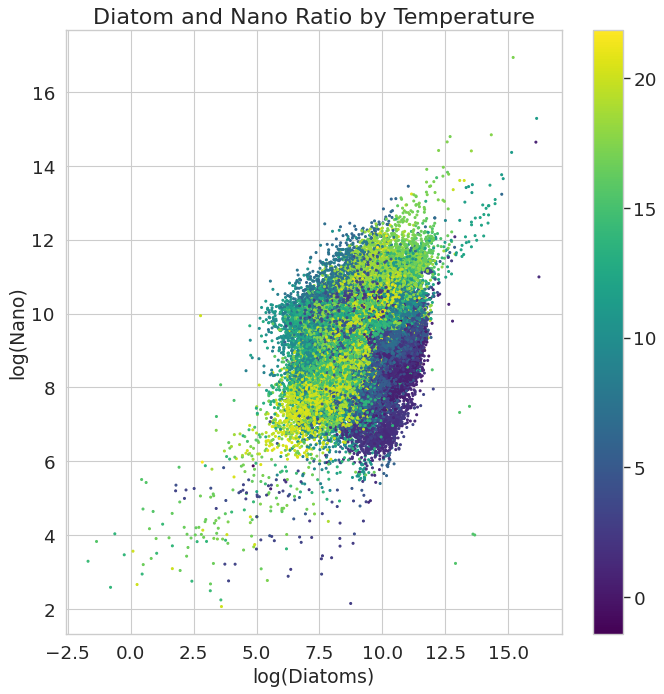

In [108]:
from matplotlib.pyplot import figure
from scipy.stats import gaussian_kde #req'd for density dot plot

figure(figsize=(10, 10), dpi=80) 

plt.scatter(np.log(df_joined['Diatom']),
            np.log(df_joined['Nano']),
            c=df_joined["temp"],
           cmap = "viridis",
           s = 3)
plt.colorbar()
plt.xlabel("log(Diatoms)",size = 17)
plt.ylabel("log(Nano)",size = 17)
plt.title("Diatom and Nano Ratio by Temperature",size = 20)




Text(0.5, 1.0, 'Diatom and Dino Ratio by Temperature')

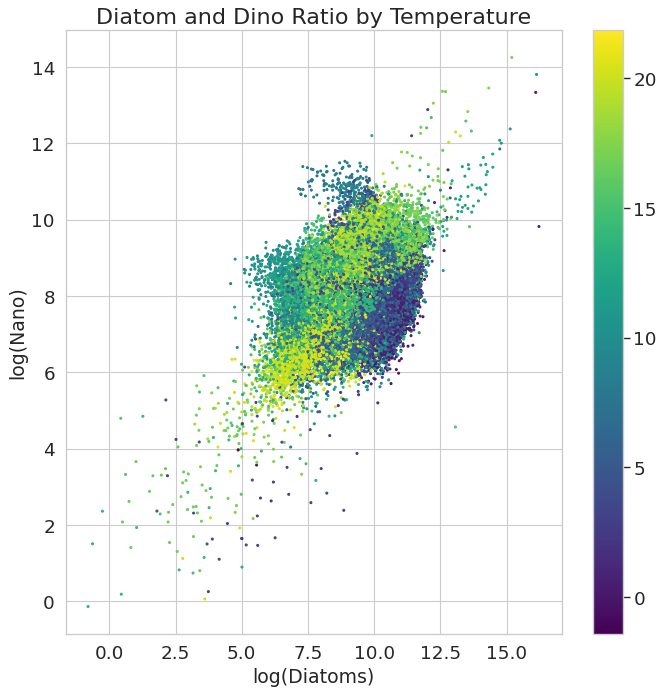

In [110]:
from matplotlib.pyplot import figure
from scipy.stats import gaussian_kde #req'd for density dot plot

figure(figsize=(10, 10), dpi=80) 

plt.scatter(np.log(df_joined['Diatom']),
            np.log(df_joined['Dinoflagellate']),
            c=df_joined["temp"],
           cmap = "viridis",
           s = 3)
plt.colorbar()
plt.xlabel("log(Diatoms)",size = 17)
plt.ylabel("log(Nano)",size = 17)
plt.title("Diatom and Dino Ratio by Temperature",size = 20)



Text(0, 0.5, 'Diatom/Dino Ratio')

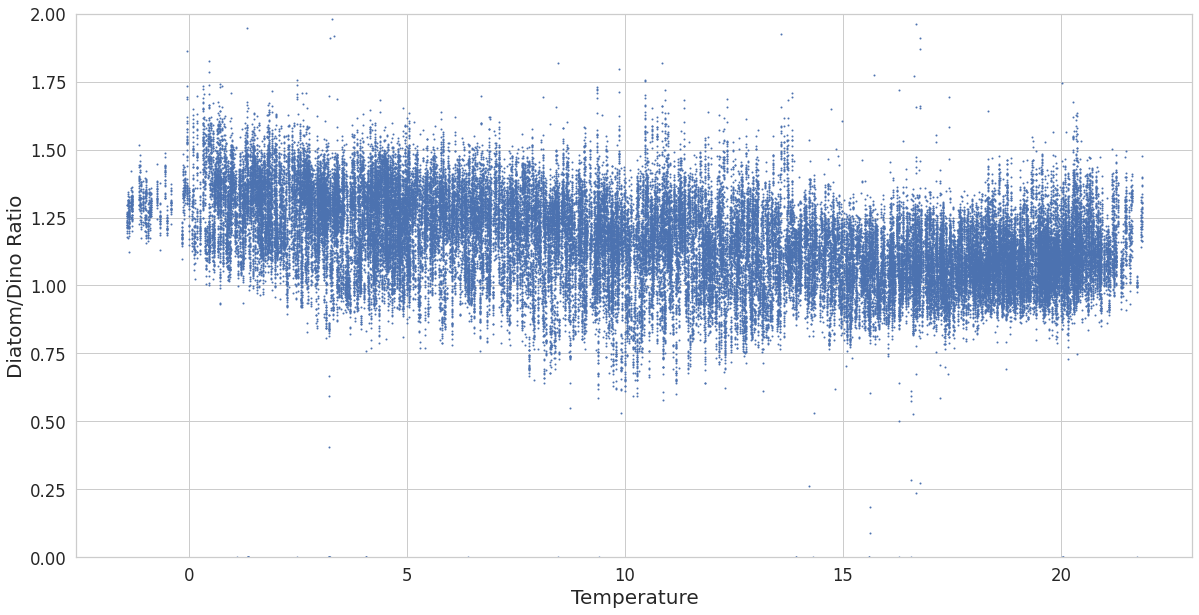

In [121]:
fig, ax = plt.subplots(figsize=(20,10))

df_joined["Diatom_Dino"]=np.log(df_joined["Diatom"])/np.log(df_joined["Dinoflagellate"])

                                                          
ax.scatter(df_joined["temp"],
          df_joined["Diatom_Dino"]
           ,s= 1)
plt.ylim(0,2)
plt.xlabel("Temperature",size = 20)
plt.ylabel("Diatom/Dino Ratio",size = 20)

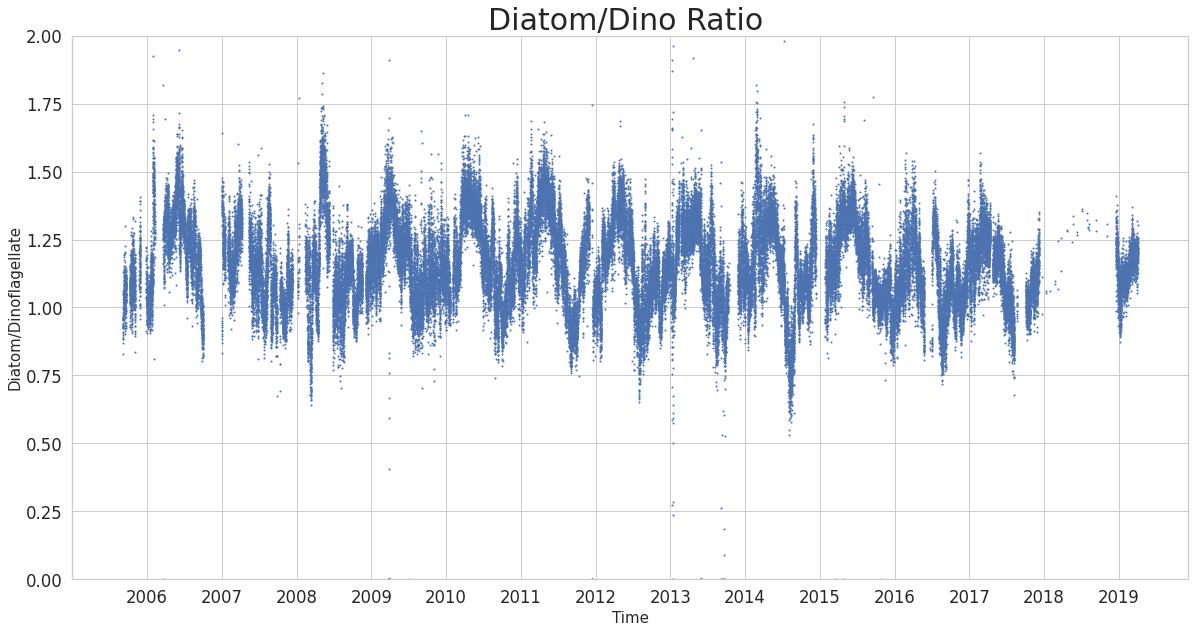

In [13]:
import matplotlib.dates as mdates

df_short["Diatom_Dino"]=np.log(df_short["Diatom"])/np.log(df_short["Dinoflagellate"])

df_short["SMA_100"]=df_short.Diatom_Dino.rolling(3).mean()
fig, ax = plt.subplots(figsize=(20,10))
                                                          
ax.scatter(df_short["datetime"],
          df_short["Diatom_Dino"]
           ,s= 1)

fmt_half_year = mdates.MonthLocator(interval=12)
ax.xaxis.set_major_locator(fmt_half_year)

# ax.plot(df_short["datetime"],df_short["SMA_100"],color = "red")

plt.xlabel("Time",size = 15)
plt.ylabel("Diatom/Dinoflagellate",size = 15)
plt.ylim((0,2))
plt.title("Diatom/Dino Ratio ",size = 30)

date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)


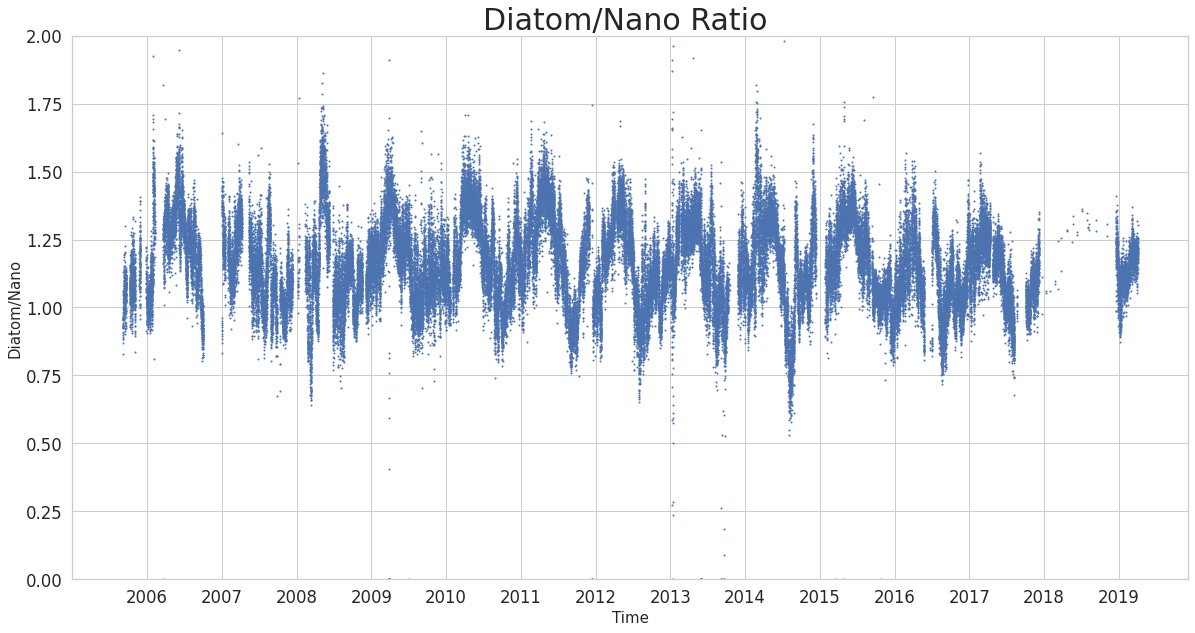

In [14]:
import matplotlib.dates as mdates


fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(df_short["datetime"],
            np.log(df_short["Diatom"])/np.log(df_short["Dinoflagellate"])
           ,s= 1)

fmt_half_year = mdates.MonthLocator(interval=12)
ax.xaxis.set_major_locator(fmt_half_year)

plt.xlabel("Time",size = 15)
plt.ylabel("Diatom/Nano",size = 15)
plt.ylim((0,2))
plt.title("Diatom/Nano Ratio ",size = 30)

date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
